# **Image Quality Assessment: Comparing Similarity Metrics Between SSIM and DISTS**

In [10]:
!pip install torch torchvision numpy matplotlib scipy
!pip install dists-pytorch
!pip install torchvision matplotlib

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter



## 1.   **SSIM**



Upload ảnh gốc:


Saving 13-0.jpg to 13-0.jpg
Upload các ảnh nhiễu (nhấn Ctrl + Enter để chọn nhiều ảnh):


Saving 13-1.jpg to 13-1.jpg
Saving 13-2.jpg to 13-2.jpg
Saving 13-3.jpg to 13-3.jpg
Saving 13-4.jpg to 13-4.jpg
Saving 13-5.jpg to 13-5.jpg
Using win_size=7 for SSIM calculation.
Using win_size=7 for SSIM calculation.
Using win_size=7 for SSIM calculation.
Using win_size=7 for SSIM calculation.
Using win_size=7 for SSIM calculation.


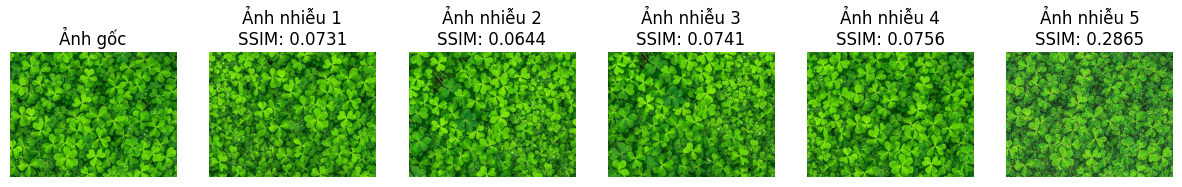

In [21]:
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt

# Hàm tính SSIM
def compute_ssim(img1, img2):
    min_side = min(img1.shape[:2])
    win_size = min(7, min_side) if min_side >= 3 else 3
    print(f"Using win_size={win_size} for SSIM calculation.")
    score, _ = ssim(img1, img2, full=True, channel_axis=-1, win_size=win_size)
    return score

# Hàm resize ảnh nếu quá nhỏ
def resize_if_needed(img, min_size=7):
    h, w = img.shape[:2]
    if h < min_size or w < min_size:
        scale = min_size / min(h, w)
        new_size = (int(w * scale), int(h * scale))
        print(f"Resizing image from ({h}, {w}) to {new_size}.")
        img = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)
    return img

# Hiển thị ảnh và tính SSIM
def display_images_and_ssim(original_path, modified_paths):
    # Đọc ảnh gốc
    original_img = cv2.imread(original_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = resize_if_needed(original_img)

    # Tạo một figure để hiển thị
    plt.figure(figsize=(15, 5))

    # Hiển thị ảnh gốc
    plt.subplot(1, len(modified_paths) + 1, 1)
    plt.imshow(original_img)
    plt.title("Ảnh gốc")
    plt.axis("off")

    # Lặp qua từng ảnh nhiễu
    for i, modified_path in enumerate(modified_paths):
        # Đọc ảnh nhiễu
        modified_img = cv2.imread(modified_path)
        modified_img = cv2.cvtColor(modified_img, cv2.COLOR_BGR2RGB)
        modified_img = resize_if_needed(modified_img)

        # Tính SSIM
        ssim_score = compute_ssim(original_img, modified_img)

        # Hiển thị kết quả
        plt.subplot(1, len(modified_paths) + 1, i + 2)
        plt.imshow(modified_img)
        plt.title(f"Ảnh nhiễu {i + 1}\nSSIM: {ssim_score:.4f}")
        plt.axis("off")

    plt.show()

# Test với ảnh của bạn
if __name__ == "__main__":
    from google.colab import files

    # Upload ảnh gốc
    print("Upload ảnh gốc:")
    original_file = files.upload()
    original_path = list(original_file.keys())[0]

    # Upload nhiều ảnh nhiễu
    print("Upload các ảnh nhiễu (nhấn Ctrl + Enter để chọn nhiều ảnh):")
    modified_files = files.upload()
    modified_paths = list(modified_files.keys())

    # Hiển thị và tính SSIM
    display_images_and_ssim(original_path, modified_paths)

## 2.   **DISTS**

Upload ảnh gốc:


Saving 13-0.jpg to 13-0 (1).jpg
Upload các ảnh nhiễu (nhấn Ctrl + Enter để chọn nhiều ảnh):


Saving 13-1.jpg to 13-1 (1).jpg
Saving 13-2.jpg to 13-2 (1).jpg
Saving 13-3.jpg to 13-3 (1).jpg
Saving 13-4.jpg to 13-4 (1).jpg
Saving 13-5.jpg to 13-5 (1).jpg


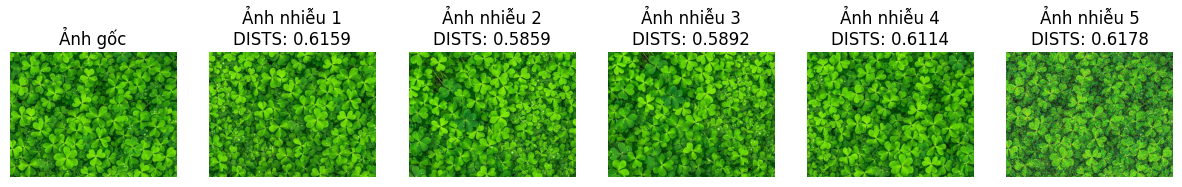

In [22]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Định nghĩa mô hình DISTS
class DISTS(nn.Module):
    def __init__(self):
        super(DISTS, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features
        for param in self.parameters():
            param.requires_grad = False
        self.feature_layers = [2, 7, 14, 21, 28]

    def forward_once(self, x):
        features = []
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

    def forward(self, ref, dist):
        ref_features = self.forward_once(ref)
        dist_features = self.forward_once(dist)
        weights = [0.1, 0.1, 0.2, 0.3, 0.3]
        score = 0.0

        for i in range(len(ref_features)):
            ref_mean = ref_features[i].mean(dim=[2, 3], keepdim=True)
            dist_mean = dist_features[i].mean(dim=[2, 3], keepdim=True)
            ref_std = torch.sqrt(((ref_features[i] - ref_mean) ** 2).mean(dim=[2, 3], keepdim=True) + 1e-8)
            dist_std = torch.sqrt(((dist_features[i] - dist_mean) ** 2).mean(dim=[2, 3], keepdim=True) + 1e-8)
            structure = (2 * ref_mean * dist_mean + 1e-8) / (ref_mean**2 + dist_mean**2 + 1e-8)
            structure *= (2 * ref_std * dist_std + 1e-8) / (ref_std**2 + dist_std**2 + 1e-8)
            ref_norm = (ref_features[i] - ref_mean) / (ref_std + 1e-8)
            dist_norm = (dist_features[i] - dist_mean) / (dist_std + 1e-8)
            texture = 1 - 0.5 * torch.mean((ref_norm - dist_norm)**2)
            layer_score = weights[i] * (0.5 * structure.mean() + 0.5 * texture)
            score += layer_score

        return score

# Hàm tải ảnh
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img

# Hàm tính DISTS score
def compute_dists(ref_path, dist_path, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    # Load ảnh
    ref_img = load_image(ref_path).to(device)
    dist_img = load_image(dist_path).to(device)

    # Tính DISTS
    score = model(ref_img, dist_img).item()
    return score

# Hiển thị ảnh và tính toán chỉ số DISTS
def display_images_and_dists(ref_path, dist_paths, model):
    # Load và hiển thị ảnh gốc
    ref_img = Image.open(ref_path).convert('RGB')

    # Tạo một figure để hiển thị
    plt.figure(figsize=(15, 5))

    # Hiển thị ảnh gốc
    plt.subplot(1, len(dist_paths) + 1, 1)
    plt.imshow(ref_img)
    plt.title("Ảnh gốc")
    plt.axis("off")

    # Lặp qua từng ảnh nhiễu
    for i, dist_path in enumerate(dist_paths):
        # Tính chỉ số DISTS
        dists_score = compute_dists(ref_path, dist_path, model)

        # Load và hiển thị ảnh nhiễu
        dist_img = Image.open(dist_path).convert('RGB')
        plt.subplot(1, len(dist_paths) + 1, i + 2)
        plt.imshow(dist_img)
        plt.title(f"Ảnh nhiễu {i + 1}\nDISTS: {dists_score:.4f}")
        plt.axis("off")

    plt.show()

# Test với ảnh của bạn
if __name__ == "__main__":
    from google.colab import files

    # Upload ảnh gốc
    print("Upload ảnh gốc:")
    ref_file = files.upload()
    ref_path = list(ref_file.keys())[0]

    # Upload nhiều ảnh nhiễu
    print("Upload các ảnh nhiễu (nhấn Ctrl + Enter để chọn nhiều ảnh):")
    dist_files = files.upload()
    dist_paths = list(dist_files.keys())

    # Tạo mô hình DISTS
    dists_model = DISTS()

    # Hiển thị và tính DISTS
    display_images_and_dists(ref_path, dist_paths, dists_model)